In [3]:
import tensorflow as tf
import gc
import numpy as np
import scipy.sparse as sp
import keras

## Fetching data from txt

In [4]:
files = ['combined_data_1.txt',
         'combined_data_2.txt',
         'combined_data_3.txt',
         'combined_data_4.txt']
movie = -1
movies, users, ratings = [],[],[]

for name in files:
    with open(name, "r") as file:
        for line in file:
            if line.endswith(':\n'):
                movie = int(line.split(':')[0]) - 1
            else:
                user_rate = line.split(',')
                user = int(user_rate[0])
                rate = int(user_rate[1])
                
                movies.append(movie)
                users.append(user)
                ratings.append(rate)
                
gc.collect()

22

## Convert to coordinate matrix

In [5]:
movies = np.array(movies, dtype = np.int32)
ratings = np.array(ratings, dtype = np.int8)
users = np.array(users, dtype = np.int32)
_, indices = np.unique(users, return_inverse=True)
data = sp.coo_matrix((ratings, (indices, movies)), dtype = np.int8)
gc.collect()

20

## Split data to train-test

In [6]:
from sklearn.model_selection import train_test_split
train_row, test_row, train_col, test_col, train_data, test_data = train_test_split(
    data.row, data.col, data.data, test_size=0.2)

shape = data.shape

train = sp.coo_matrix(
    (train_data, (train_row, train_col)), shape=shape, dtype = np.int8)
test = sp.coo_matrix(
    (test_data, (test_row, test_col)), shape=shape, dtype = np.int8)
gc.collect()

0

# DMF Model
<img src="model.png">

### Input: User-Item non-zero ratings matrix Y
### Output: User latent factor P , Item latent factor Q
### Training algorithm: 
- Random wieghts initialization
- for iter in range(max_iter)
 - for each interaction of User i and Item j in Y
      1. Set 
      $
      \begin{align}
                \ P_i
      \end{align}
      $
        , 
      $
      \begin{align}
                \ Q_i
      \end{align}
      $
      using forward propagation 
      2. Set output: 
     $
     \begin{equation*}
         \hat{Y_{ij}} = cosine( 
         \ P_i ,
         \ Q_j ) = 
         \frac{P_i^T Q_j}{||P_i|| . ||Q_j||}
     \end{equation*}
     $

      3. Activation function: 
      $
      \begin{equation*}
            \hat{Y_{ij}} = max(µ, 
            \hat{Y_{ij}} )
      \end{equation*}
      $ 
                µ is a very small number i.e 10^-7
      4. set Loss using this loss function:
        \begin{equation*}
            Loss = 
            \sum_{i, j->Y} 
            \left( 
                \frac{Y_{ij}}{max(Y)}
                \ log
                \hat{Y_{ij}}  +
                \left(1-
                    \frac{Y_{ij}}{max(Y)}
                \right)
                \ log( 1 - 
                \hat{Y_{ij}} )
            \right) 
        \end{equation*}
                max(Y) is the max rating value (i.e 5)
      5. Use back propagation to optimize model parameters

## Reshape data with model input

In [7]:
gc.collect()
data_arr = data.toarray()

In [8]:
data_arrT = data_arr.T
gc.collect()

20

In [19]:
X1, X2, y = [],[],[]
for idx in range(10000):
    u, i, r = indices[idx], movies[idx], ratings[idx]
    X1.append(data_arr[u])
    X2.append(data_arrT[i])
    y.append(r)

X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y, test_size=0.2)

print(X1)
print(X1.shape)

print(X2)
print(X2.shape)

print(np.max(y))
print(y.shape)

[[3 0 0 ... 3 0 4]
 [5 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(10000, 17770)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 5 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
(10000, 480189)
5
(10000,)


In [20]:
gc.collect()

12822

In [31]:
class DMF:
    
    def __init__(self, layers):
        self.layers = layers      # layers has number of neurons in each layer
    
    @staticmethod
    def cosine_similarity(inputs, epsilon=1.0e-6, delta=1e-12):
        x, y = inputs[0], inputs[1]
        numerator = keras.backend.sum(x * y, axis=1, keepdims=True)
        denominator = keras.backend.sqrt(keras.backend.sum(x * x, axis=1, keepdims=True)
                                       * keras.backend.sum(y * y, axis=1, keepdims=True))
        cosine_similarity = numerator / keras.backend.maximum(denominator, delta)
        return keras.backend.maximum(cosine_similarity, epsilon)
    
    @staticmethod
    def loss_function(y_true, y_pred):
        return -keras.backend.sum((
              ( (y_true/5)       * keras.backend.log(y_pred) )
            + ( (1 - (y_true/5)) * keras.backend.log(1 - y_pred) )
        ))
        
    def build_model(self):
        hidden_count = len(self.layers)
        
        P_input = keras.Input(shape=(17770,), name = 'P_input')
        P_last = P_input
        for i in range(hidden_count):
            P_last = keras.layers.Dense(self.layers[i], activation="relu", use_bias = True)(P_last)
        
        Q_input = keras.Input(shape=(480189,), name = 'Q_input')
        Q_last = Q_input
        for i in range(hidden_count):
            Q_last = keras.layers.Dense(self.layers[i], activation="relu", use_bias = True)(Q_last)
        
        output = keras.layers.Lambda(function=self.cosine_similarity, name='output')([P_last, Q_last])
        
        self.model = keras.Model(inputs=[P_input, Q_input], outputs=output, name="DMF_model")
        
        self.model.summary()
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(lr=0.0001),
            loss = self.loss_function,
            metrics=[keras.metrics.RootMeanSquaredError(name = 'RMSE')]
        )
        
    

In [32]:
dmf = DMF(layers = [84, 64])
dmf.build_model()

Model: "DMF_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
P_input (InputLayer)            [(None, 17770)]      0                                            
__________________________________________________________________________________________________
Q_input (InputLayer)            [(None, 480189)]     0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 84)           1492764     P_input[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 84)           40335960    Q_input[0][0]                    
__________________________________________________________________________________________

In [33]:
history = dmf.model.fit(
            {"P_input": X1_train, "Q_input": X2_train},
            y = y_train,
            batch_size=256,
            validation_split=0.3,
            epochs=600)

Epoch 1/600
22/22 [==============================] - 18s 801ms/step - loss: 166.9537 - RMSE: 3.0234 - val_loss: 157.1381 - val_RMSE: 2.9899
Epoch 2/600
22/22 [==============================] - 14s 657ms/step - loss: 155.9299 - RMSE: 2.9693 - val_loss: 155.6819 - val_RMSE: 2.9758
Epoch 3/600
22/22 [==============================] - 15s 679ms/step - loss: 151.9522 - RMSE: 2.9639 - val_loss: 155.5995 - val_RMSE: 2.9641
Epoch 4/600
22/22 [==============================] - 15s 694ms/step - loss: 147.7768 - RMSE: 2.9533 - val_loss: 155.0117 - val_RMSE: 2.9764
Epoch 5/600
22/22 [==============================] - 15s 677ms/step - loss: 143.1206 - RMSE: 2.9483 - val_loss: 154.9042 - val_RMSE: 2.9810
Epoch 6/600
22/22 [==============================] - 14s 628ms/step - loss: 138.1533 - RMSE: 2.9388 - val_loss: 154.8006 - val_RMSE: 2.9780
Epoch 7/600
22/22 [==============================] - 12s 555ms/step - loss: 133.6458 - RMSE: 2.9291 - val_loss: 154.7913 - val_RMSE: 2.9720
Epoch 8/600
22/22 [=

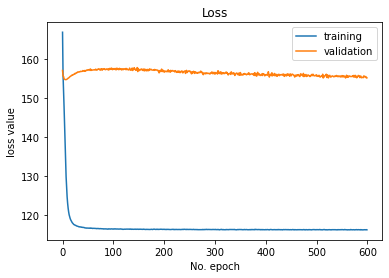

In [34]:
import matplotlib.pyplot  as plt
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

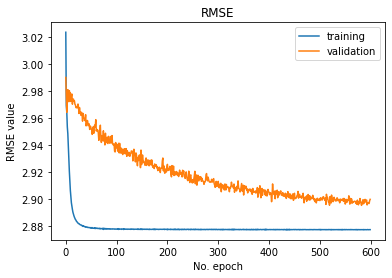

In [35]:
import matplotlib.pyplot  as plt
plt.plot(history.history['RMSE'], label='training')
plt.plot(history.history['val_RMSE'], label='validation')
plt.title('RMSE')
plt.ylabel('RMSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

## RMSE on test data

In [ ]:
y_pred = dmf.model.predict({"P_input": X1_test, "Q_input": X2_test})
m = keras.metrics.RootMeanSquaredError()
m.update_state(y_test, y_pred)
print(f'RMSE = {m.result()}')